<a href="https://colab.research.google.com/github/laolucharles1/Data-Analytics-Machine-Learning-Projects/blob/main/Visualizing_Convet_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Visualizing convet filters

Useful for understanding precisely what visual patterns or concept each filter in a convet is receptive to

Defining the loss tensor for filter visualization

In [24]:
img_path = "/content/drive/MyDrive/kaggle_original_data/test/cats/cat.1700.jpg"

from keras.preprocessing import image #preprocesses the image into a 4D tensor
import numpy as np

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


In [22]:
from keras.applications import VGG16
from keras import backend as K
import keras

model = VGG16(weights = 'imagenet', include_top = False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [16]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block4_conv1
block4_conv2
block4_conv3
block5_conv1
block5_conv2
block5_conv3


In [27]:
layer_name = "block3_conv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

Using the feature extractor

In [29]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [30]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

Loss maximization via stochastic gradient ascent

In [31]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

**Function to generate filter visualizations**

In [32]:
import numpy as np

img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

Utility function to convert a tensor into a valid image

In [33]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

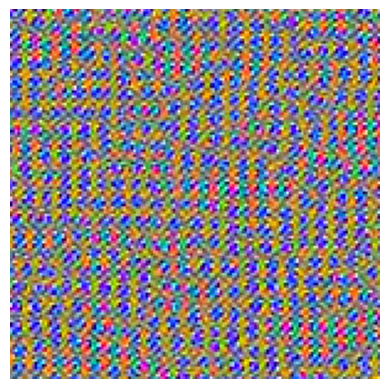

In [38]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

Generating a grid of all filter response patterns in a layer

In [ ]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

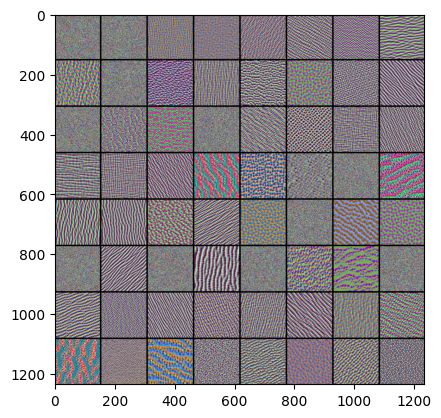

In [42]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

image = mpimg.imread("/content/filters_for_layer_block3_conv1.png")
plt.imshow(image)
plt.show()